This Notebook trains a simple ViT on toy data using LFP and Gradient Descent

### Imports

In [12]:
import os
from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as tnn
import torcheval.metrics
import torchvision.datasets as tvisiondata
import torchvision.transforms as T
from tqdm import tqdm

import datasets
import transformers
import time
import random

import warnings

from lxt import rules as lrules
from lxt.modules import INIT_MODULE_MAPPING

from zennit import types as ztypes

from lfprop.propagation import (
    propagator_vit as propagator,
)  # LFP propagator for ViT
from lfprop.rewards import reward_functions as rewards  # Reward Functions
from lfprop.rewards import rewards as loss_fns

### Parameters

In [13]:
savepath = "/media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f51/reward-backprop/resubmission-1-experiments/beans-vit-training-camera-ready"
dataset_path = "/media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f51/Datasets/huggingface/beans"
# TODO double check model pretraining
model_path = 'google/vit-base-patch16-224-in21k'
os.makedirs(savepath, exist_ok=True)

batch_size = 32
n_channels = 1
n_outputs = 10

lr = 2e-4
momentum = 0.9
epochs = 20
retrain = True

seeds = [7240]#, 5110, 5628]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load Dataset

In [14]:
ds = datasets.load_dataset('nateraw/beans')
ds

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'labels'],
        num_rows: 128
    })
})

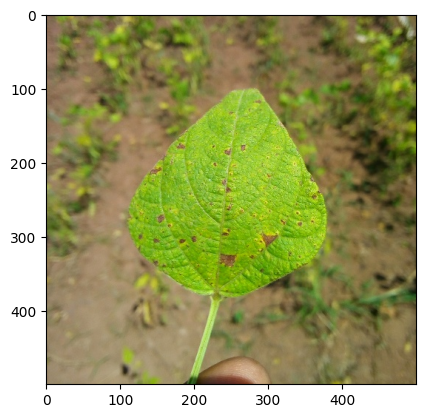

In [15]:
imfile = ds['train'][400]['image_file_path']
image = Image.open(imfile)
plt.imshow(image)

In [16]:
feature_extractor = transformers.ViTImageProcessor.from_pretrained(model_path)
feature_extractor

def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([Image.open(x) for x in example_batch['image_file_path']], return_tensors='pt')

    inputs['labels'] = example_batch['labels']
    return inputs

prepared_ds = ds.with_transform(transform)
prepared_ds['test'][0]
print(prepared_ds['test'][0]["pixel_values"].shape)

torch.Size([3, 224, 224])


In [17]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }
    
training_loader = torch.utils.data.DataLoader(prepared_ds["train"], shuffle=True, collate_fn=collate_fn, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(prepared_ds["test"], shuffle=False, collate_fn=collate_fn, batch_size=batch_size)

### Trainer Class

In [18]:
class ViTTrainer:
    def __init__(
        self,
        trainer_id,
        train_loader,
        test_loader,
        classlabels,
        criterion,
        device,
        propagator=None,
        seed = None,
        default_model_checkpoint='google/vit-base-patch16-224-in21k',
    ):
        self.id = trainer_id
        self.model = None
        self.optimizer = None
        self.criterion = criterion
        self.classlabels = classlabels
        self.scheduler = None
        self.device = device
        self.global_epoch = 0
        self.global_step = 0
        self.clock_times = []
        self.propagator = propagator
        self.default_model_checkpoint = default_model_checkpoint

        self.train_loader = train_loader
        self.test_loader = test_loader
        self.seed = seed
        self.best_acc = 0

    def reset(self):
        del self.model
        self.model = None
        del self.optimizer
        self.optimizer = None

    def set_random_seeds(self, seed):
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        torch.manual_seed(seed)
        os.environ["PYTHONHASHSEED"] = str(seed)

        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.enabled = False

    def grad_step(self, batch):

        self.model.train()
        with torch.enable_grad():
            self.optimizer.zero_grad()
            
            labels = batch.get("labels", None)
            inputs = batch.get("pixel_values", None)
            
            start1 = time.time()
            out = self.model(pixel_values = inputs)["logits"]
            loss = self.criterion(out, labels)
            loss.backward()
            end1 = time.time()

            # Update Clipping. Training may become unstable otherwise, especially in small models with large learning rates.
            # In larger models (e.g., VGG, ResNet), where smaller learning rates are generally utilized, not clipping updates may result in better performance.
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 3.0, 2.0)

            start2 = time.time()
            self.optimizer.step()
            end2 = time.time()

            clock_time = end2-start2 + end1-start1
            self.clock_times.append(clock_time)

        self.model.eval()

        self.global_step += 1

    def lfp_step(self, batch):
        self.model.train()

        with torch.enable_grad():
            self.optimizer.zero_grad()
            
            with self.propagator.context(self.model, dummy_inputs={"pixel_values": torch.randn(1, 3, 224, 224, device=device)}) as modified:
                
                labels = batch.get("labels", None)
                inputs = batch.get("pixel_values", None).requires_grad_(True)
                
                start1 = time.time()
                outputs = modified(pixel_values = inputs)["logits"]
                #print(outputs.sum())

                # Calculate rewardLpt in memory
                reward = torch.from_numpy(self.criterion(outputs, labels).detach().cpu().numpy()).to(device)

                # Calculate LFP and write into .feedback attribute of parameters
                torch.autograd.grad((outputs,), (inputs,), grad_outputs=(reward,), retain_graph=False)[0]
                end1 = time.time()

                # Write LFP Values into .grad attributes. Note the negative sign: LFP requires maximization instead of minimization like gradient descent
                for name, param in self.model.named_parameters():
                    if param.requires_grad:
                        #print(name, param.feedback.min(), param.feedback.max())
                        param.grad = -param.feedback

                # Update Clipping. Training may become unstable otherwise, especially in small models with large learning rates.
                # In larger models (e.g., VGG, ResNet), where smaller learning rates are generally utilized, not clipping updates may result in better performance.
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 3.0, 2.0)

                # Optimization step
                start2 = time.time()
                self.optimizer.step()
                end2 = time.time()
                
                clock_time = end2-start2 + end1-start1
                self.clock_times.append(clock_time)

        self.model.eval()

        self.global_step += 1

    def train(
        self,
        epochs,
        savepath=None,
        fromscratch=False,
    ):
        self.set_random_seeds(self.seed)
        
        if not fromscratch and savepath:
            self.load(savepath, "last")
        elif fromscratch:
            self.load(savepath, "init")
            
        train_evals = []
        test_evals = []
            
        eval_stats_train = self.eval(datasplit="train")
        eval_stats_test = self.eval(datasplit="test")
        train_evals.append(eval_stats_train)
        test_evals.append(eval_stats_test)

        print(
            "Initial Eval: (Train Criterion) {:.2f}; (Train Accuracy) {:.2f}; (Test Criterion) {:.2f}; (Test Accuracy) {:.2f}".format(
                float(np.mean(eval_stats_train["criterion"])),
                (
                    float(eval_stats_train["accuracy"])
                ),
                float(np.mean(eval_stats_test["criterion"])),
                (
                    float(eval_stats_test["accuracy"])
                ),
            )
        )

        for epoch in range(epochs):
            with tqdm(total=len(self.train_loader)) as pbar:
                for index, batch in enumerate(self.train_loader):

                    batch = {k: v.to(device) for k, v in batch.items()}

                    if self.propagator is None:
                        # Grad Step
                        self.grad_step(batch)
                    else:
                        # LFP Step
                        self.lfp_step(batch)
                    
                    pbar.update(1)

            eval_stats_train = self.eval(datasplit="train")
            eval_stats_test = self.eval(datasplit="test")
            train_evals.append(eval_stats_train)
            test_evals.append(eval_stats_test)

            print(
                "Epoch {}/{}: (Train Criterion) {:.2f}; (Train Accuracy) {:.2f}; (Test Criterion) {:.2f}; (Test Accuracy) {:.2f}".format(
                    epoch + 1,
                    epochs,
                    float(np.mean(eval_stats_train["criterion"])),
                    (
                        float(eval_stats_train["accuracy"])
                    ),
                    float(np.mean(eval_stats_test["criterion"])),
                    (
                        float(eval_stats_test["accuracy"])
                    ),
                )
            )

            self.global_epoch += 1

            if savepath:
                self.save(savepath, "last", train_evals=train_evals, test_evals=test_evals)
                
                accuracy = (
                    float(eval_stats_test["accuracy"])
                )
                if accuracy > self.best_acc:
                    self.save(savepath, "best", train_evals=train_evals, test_evals=test_evals)
                    self.best_acc = accuracy
    
    def eval(self, datasplit="test"):
        """
        Evaluates the model on a single dataset
        """
        
        loader = self.train_loader if datasplit == "train" else self.test_loader
        
        eval_metrics = {
            "criterion": torcheval.metrics.Mean(device=device),
            "accuracy": torcheval.metrics.MulticlassAccuracy(average="micro", num_classes=3, k=1, device=device),
        }

        self.model.eval()

        # Iterate over Data Loader
        for index, batch in enumerate(loader):
            batch = {k: v.to(device) for k, v in batch.items()}
            labels = batch.get("labels", None)
            inputs = batch.get("pixel_values", None).requires_grad_(True)

            with torch.no_grad():
                # Get model predictions
                outputs = self.model(pixel_values = inputs)["logits"]
                print(outputs.shape)

            with torch.set_grad_enabled(True):
                # Get criterion
                crit = self.criterion(outputs, labels)

            for k, v in eval_metrics.items():
                if k == "criterion":
                    eval_metrics[k].update(crit)
                else:
                    eval_metrics[k].update(outputs, labels)

        return_dict = {m: metric.compute().detach().cpu().numpy() for m, metric in eval_metrics.items()}

        # Return evaluation
        return return_dict

    def save(self, savepath, saveappendage, train_evals=None, test_evals=None):
        cfg_checkpoint = {
            "epoch": self.global_epoch,
            "step": self.global_step,
            "random_state": {
                "torch": torch.get_rng_state(),
                "cuda": torch.cuda.get_rng_state(self.device),
                "numpy": np.random.get_state(),
                "random": random.getstate(),
            },
        }
        if self.optimizer:
            cfg_checkpoint["optimizer"] = self.optimizer.state_dict()
        if self.scheduler:
            cfg_checkpoint["scheduler"] = self.scheduler.state_dict()
        if self.clock_times:
            cfg_checkpoint["clock_times"] = self.clock_times
        if train_evals:
            cfg_checkpoint["train_evals"] = train_evals
        if test_evals:
            cfg_checkpoint["test_evals"] = test_evals

        torch.save(cfg_checkpoint, os.path.join(savepath, f"cfg_ckpt-{self.id}-{saveappendage}.pt"))
        self.model.save_pretrained(os.path.join(savepath, f"model_{self.id}-{saveappendage}"))

    def load(self, savepath, saveappendage):
        
        model_checkpoint = None
        optimizer_checkpoint = None
        
        train_evals = None
        test_evals = None

        if os.path.exists(os.path.join(savepath, f"cfg_ckpt-{self.id}-{saveappendage}.pt")):

            print(f"Loading from {os.path.join(savepath, f'cfg_ckpt-{self.id}-{saveappendage}.pt')}")

            cfg_checkpoint = torch.load(os.path.join(savepath, f"cfg_ckpt-{self.id}-{saveappendage}.pt"), weights_only=False)
            if self.optimizer:
                optimizer_checkpoint = cfg_checkpoint["optimizer"]
            if self.scheduler:
                self.scheduler.load_state_dict(cfg_checkpoint["scheduler"])
            if "clock_times" in cfg_checkpoint:
                self.clock_times = cfg_checkpoint["clock_times"]
            if "train_evals" in cfg_checkpoint:
                train_evals = cfg_checkpoint["train_evals"]
            if "test_evals" in cfg_checkpoint:
                test_evals = cfg_checkpoint["test_evals"]
            self.global_epoch = cfg_checkpoint["epoch"]
            self.global_step = cfg_checkpoint["step"]

            torch.set_rng_state(cfg_checkpoint["random_state"]["torch"])
            torch.cuda.set_rng_state(cfg_checkpoint["random_state"]["cuda"], device)
            np.random.set_state(cfg_checkpoint["random_state"]["numpy"])
            random.setstate(cfg_checkpoint["random_state"]["random"])
            
            model_checkpoint = os.path.join(savepath, f"model_{self.id}-{saveappendage}")
        
        if not model_checkpoint:
            model_checkpoint = self.default_model_checkpoint
        
        self.model = transformers.ViTForImageClassification.from_pretrained(
            model_checkpoint,
            num_labels=len(self.classlabels),
            id2label={str(i): c for i, c in enumerate(self.classlabels)},
            label2id={c: str(i) for i, c in enumerate(self.classlabels)},
            _attn_implementation = "eager"
        )
        
        # Note: We aim to finetune the model here, so we set the embedding parameters to not require grad.
        for name, param in self.model.vit.embeddings.named_parameters():
            param.requires_grad = False

        self.model.to(device)
        
        if not optimizer_checkpoint:
            #self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr)
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        else:
            self.optimizer.load_state_dict(optimizer_checkpoint)
            
        return train_evals, test_evals

### Set Up LFP

In [19]:
# Initialize the LFP Composite (cf. "composites" in zennit or lxt).
# This composite is tailored to the specific model.
propagation_composites = {
    "lfp-epsilon": propagator.LFPEpsilonComposite(),
    "vanilla-gradient": None,
}

# Initialize the Reward Function.
# Here we use the Reward Function suggested in the LFP-Paper, but check out other reward functions in ./lfp/rewards/reward_functions.py
critrions = {
    "lfp-epsilon": rewards.SoftmaxLossReward(device),
    "vanilla-gradient": loss_fns.CustomCrossEntropyLoss()
}

### Define Trainers

In [20]:
trainers = {}

for prop_comp in propagation_composites.keys():
    trainers[prop_comp] = []
    for seed in seeds:
        trainer_id = f"{prop_comp}-{seed}"
        
        trainers[prop_comp].append(
            ViTTrainer(
                trainer_id,
                training_loader,
                test_loader,
                ds['train'].features['labels'].names,
                critrions[prop_comp],
                device,
                propagation_composites[prop_comp],
                seed,
                default_model_checkpoint=model_path
            )
        )

### Training Loop

In [ ]:
warnings.filterwarnings("ignore")

eval_stats_best = { p: {
        "train": [],
        "test": [],
        "clock_times": []
    } for p in propagation_composites.keys()
}

eval_stats_last = { p: {
        "train": [],
        "test": [],
        "clock_times": []
    } for p in propagation_composites.keys()
}

# Training Loop
for prop_comp, p_trainers in trainers.items():
    for t, trainer in enumerate(p_trainers):
        print(f"Trainer {t+1}/{len(p_trainers)} for propgator {prop_comp}")
        if not os.path.exists(os.path.join(savepath, f"cfg_ckpt-{trainer.id}-best.pt")) or retrain:
            trainer.train(
                epochs,
                savepath=savepath,
                fromscratch=True,
            )
            trainer.reset()
        train_stats, test_stats = trainer.load(
            savepath,
            "best",
        )
        clock_times = trainer.clock_times
        eval_stats_best[prop_comp]["train"].append(train_stats)
        eval_stats_best[prop_comp]["test"].append(test_stats)
        eval_stats_best[prop_comp]["clock_times"].append(clock_times)
        trainer.reset()
        
        train_stats, test_stats = trainer.load(
            savepath,
            "last",
        )
        clock_times = trainer.clock_times
        eval_stats_last[prop_comp]["train"].append(train_stats)
        eval_stats_last[prop_comp]["test"].append(test_stats)
        eval_stats_last[prop_comp]["clock_times"].append(clock_times)
        trainer.reset()

Trainer 1/1 for propgator lfp-epsilon


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])
torch.Size([32, 3])


### Plot Results

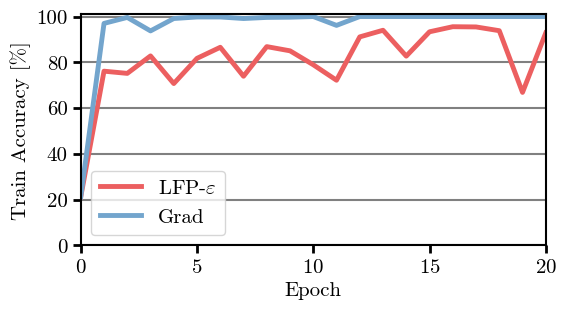

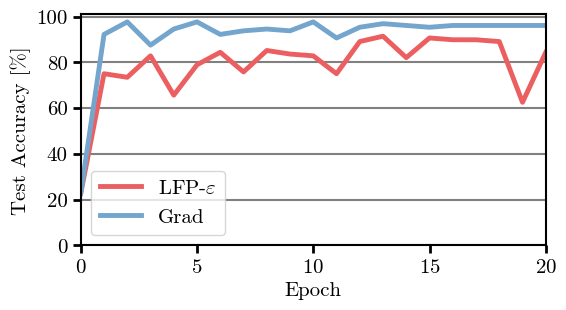

: 

In [ ]:
# Plot Settings
# Set font properties.
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.cm as cm
import copy
font_path = plt.matplotlib.get_data_path() + "/fonts/ttf/cmr10.ttf"
cmfont = font_manager.FontProperties(fname=font_path)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = cmfont.get_name()
plt.rcParams["mathtext.fontset"] = "cm"

# Set font size.
plt.rcParams["font.size"] = 15

# Disable unicode minus.
plt.rcParams["axes.unicode_minus"] = False

# Use mathtext for axes formatters.
plt.rcParams["axes.formatter.use_mathtext"] = True

plt.rcParams['axes.linewidth'] = 1.5

def plot_stats_over_epochs(eval_stats, fname, colormap="Set1", split="test"):
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))

    colors = np.linspace(0, 1, 9)
    palette = cm.get_cmap(colormap)(colors)
    pastel = 0.3
    palette = (1 - pastel) * palette + pastel * np.ones((9, 4))
    
    SPLITS = {
        "train": "Train",
        "test": "Test"
    }
    
    LABELS = {
        "lfp-epsilon": r"LFP-$\varepsilon$",
        "lfp-zplus-zminus": r"LFP-$z^+z^-$",
        "vanilla-gradient": r"Grad",
    }

    for p, (prop_name, data) in enumerate(eval_stats.items()):
        plot_data = []
        clock_times = []
        for s, seed in enumerate(seeds):
            plot_data.append([data[split][s][i]["accuracy"] for i in range(len(data[split][s]))])
            clock_times.append(data["clock_times"][s])
        plot_means = np.mean(plot_data, axis=0)
        plot_stds = np.std(plot_data, axis=0)
        clock_mean = np.mean(clock_times)

        xaxis = np.arange(0, len(plot_means))

        ax.plot(xaxis, plot_means, color=palette[p], label=LABELS[prop_name], linewidth=3.5, alpha=1)
        ax.fill_between(
            xaxis,
            plot_means + plot_stds,
            plot_means - plot_stds,
            color=palette[p],
            alpha=0.2,
        )
        #ax.text(len(plot_means)-2, 0.15*p+0.05, f"{np.abs(clock_mean):.2f}" + r" $\frac{sec.}{step}$", color=palette[p], horizontalalignment="right", verticalalignment="bottom")

    linelocs = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    ax.hlines(
        linelocs,
        xmin=-1,
        xmax=xaxis[-1],
        color=(0.5, 0.5, 0.5, 1),
        linewidth=1.5,
        zorder=0,
    )

    ax.set_ylabel(f"{SPLITS[split]} Accuracy [%]")
    ax.set_xlabel("Epoch")
    ax.set_ylim([0.0, 1.01])
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_xlim([0.0, xaxis[-1]])
    ax.set_yticklabels([0, 20, 40, 60, 80, 100])
    ax.tick_params(length=6, width=2)
    # ax.set_xlim([0, 200])
    ax.legend()
    plt.show()
    fig.savefig(fname)

plot_stats_over_epochs(eval_stats_last, os.path.join(savepath, "accuracies-train.svg"), colormap="Set1", split="train")
plot_stats_over_epochs(eval_stats_last, os.path.join(savepath, "accuracies-test.svg"), colormap="Set1", split="test")